In [264]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids, CondensedNearestNeighbour

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pathlib
from glob import glob
from data_loader import get_pdf_filepaths, load_page_and_line_indexes, load_split_data, load_raw_indexes_list#, get_processed_folders_filepaths

In [268]:
from IPython import get_ipython
ip = get_ipython()
ip.InteractiveTB.set_mode(mode="Verbose")

In [89]:
def get_agg_dfs_filepaths(folder_path):
    absolute_folder_path = pathlib.Path(folder_path).resolve()
    #print(absolute_folder_path)
    pattern = str(absolute_folder_path / '**/aggregated.csv')
    #print(pattern)
    return glob(pattern)

# 0. Create dataset from the csvs of all books

In [90]:
DATA_DIR_PATH = "../data/"
PDF_SOURCE_DIR_PATH = DATA_DIR_PATH + "pdf/"
PROCESSED_DATA_DIR_PATH = DATA_DIR_PATH + "processed/"

In [91]:
file_paths = get_agg_dfs_filepaths(PROCESSED_DATA_DIR_PATH)
file_paths

['/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/lycan_08/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/2015_Book_LinearAlgebra/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/2007BoolosComputability and Logic Fifth Edition/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/christensen_04/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/williamson_94/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/2014_Book_Microeconomics/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/jacobson_14/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/morris_07/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/moltmann_97/ag

In [161]:
list_agg_dfs=[]
for path in file_paths:
    aggregated_df = pd.read_csv(path,index_col=0)
    list_agg_dfs.append(aggregated_df)
    
df = pd.concat(list_agg_dfs)

In [162]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 856879 entries, 0 to 39832
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   candidate_keyword    856871 non-null  object 
 1   length               856879 non-null  int64  
 2   is_named_entity      856879 non-null  int64  
 3   is_named_author      856879 non-null  int64  
 4   is_in_toc            856879 non-null  int64  
 5   freq                 856879 non-null  float64
 6   is_in_index          856879 non-null  int64  
 7   tfidf                856879 non-null  float64
 8   importance           856879 non-null  float64
 9   position_in_context  856879 non-null  float64
 10  POS                  856879 non-null  object 
dtypes: float64(4), int64(5), object(2)
memory usage: 78.4+ MB


# 1. Feature engineering

In [163]:
#presupposes that df is the dataset of all the book's datasets (so first I need to merge them with merge or concat)

In [164]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 856879 entries, 0 to 39832
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   candidate_keyword    856871 non-null  object 
 1   length               856879 non-null  int64  
 2   is_named_entity      856879 non-null  int64  
 3   is_named_author      856879 non-null  int64  
 4   is_in_toc            856879 non-null  int64  
 5   freq                 856879 non-null  float64
 6   is_in_index          856879 non-null  int64  
 7   tfidf                856879 non-null  float64
 8   importance           856879 non-null  float64
 9   position_in_context  856879 non-null  float64
 10  POS                  856879 non-null  object 
dtypes: float64(4), int64(5), object(2)
memory usage: 78.4+ MB


In [165]:
df.reset_index(drop=True, inplace=True)

In [166]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856879 entries, 0 to 856878
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   candidate_keyword    856871 non-null  object 
 1   length               856879 non-null  int64  
 2   is_named_entity      856879 non-null  int64  
 3   is_named_author      856879 non-null  int64  
 4   is_in_toc            856879 non-null  int64  
 5   freq                 856879 non-null  float64
 6   is_in_index          856879 non-null  int64  
 7   tfidf                856879 non-null  float64
 8   importance           856879 non-null  float64
 9   position_in_context  856879 non-null  float64
 10  POS                  856879 non-null  object 
dtypes: float64(4), int64(5), object(2)
memory usage: 71.9+ MB


In [167]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
length,856879.0,13.748048,4.678405,1.000000,11.000000,14.000000,17.000000,61.000000
is_named_entity,856879.0,0.009262,0.095790,0.000000,0.000000,0.000000,0.000000,1.000000
is_named_author,856879.0,0.002269,0.047577,0.000000,0.000000,0.000000,0.000000,1.000000
is_in_toc,856879.0,0.003747,0.061101,0.000000,0.000000,0.000000,0.000000,1.000000
freq,856879.0,0.000025,0.000144,0.000004,0.000008,0.000010,0.000015,0.021389
is_in_index,856879.0,0.010911,0.103882,0.000000,0.000000,0.000000,0.000000,1.000000
tfidf,856879.0,0.006500,0.029283,0.000000,0.000000,0.000000,0.000000,0.934752
importance,856879.0,0.433639,0.140895,-0.278195,0.344225,0.441558,0.532387,0.893139
position_in_context,856879.0,0.446068,0.262398,0.000000,0.230769,0.441027,0.650000,1.000000


In [168]:
df.dropna(inplace=True)

In [ ]:
df.

In [169]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 856871 entries, 0 to 856878
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   candidate_keyword    856871 non-null  object 
 1   length               856871 non-null  int64  
 2   is_named_entity      856871 non-null  int64  
 3   is_named_author      856871 non-null  int64  
 4   is_in_toc            856871 non-null  int64  
 5   freq                 856871 non-null  float64
 6   is_in_index          856871 non-null  int64  
 7   tfidf                856871 non-null  float64
 8   importance           856871 non-null  float64
 9   position_in_context  856871 non-null  float64
 10  POS                  856871 non-null  object 
dtypes: float64(4), int64(5), object(2)
memory usage: 78.4+ MB


In [180]:
df_scaled = pd.get_dummies(df, columns=['POS'],
prefix = ['POS'])

In [181]:
df_scaled.head()

,candidate_keyword,length,is_named_entity,is_named_author,is_in_toc,freq,is_in_index,tfidf,importance,position_in_context,...,POS_NOUN,POS_NUM,POS_PART,POS_PRON,POS_PROPN,POS_PUNCT,POS_SCONJ,POS_SYM,POS_VERB,POS_X
0,a-laying,8,0,0,0,0.000013,0,0.000000,0.662301,0.750000,...,1,0,0,0,0,0,0,0,0,0
1,a-laying police,15,0,0,0,0.000013,0,0.000000,0.662301,0.750000,...,0,0,0,0,0,0,0,0,0,0
2,aardvark,8,0,0,0,0.000013,0,0.000000,0.644323,1.000000,...,1,0,0,0,0,0,0,0,0,0
3,abandoned,9,0,0,0,0.000038,0,0.009811,0.449342,0.611827,...,0,0,0,0,0,0,0,0,1,0
4,abandoned commitment,20,0,0,0,0.000013,0,0.000000,0.392002,0.272727,...,0,0,0,0,0,0,0,0,0,0


In [182]:
df_scaled.drop(columns=['candidate_keyword'], inplace=True)

In [183]:
df_scaled_columns = df_scaled.columns
df_scaled_columns

Index(['length', 'is_named_entity', 'is_named_author', 'is_in_toc', 'freq',
       'is_in_index', 'tfidf', 'importance', 'position_in_context', 'POS_ADJ',
       'POS_ADP', 'POS_ADV', 'POS_AUX', 'POS_CCONJ', 'POS_CHUNK', 'POS_DET',
       'POS_INTJ', 'POS_NOUN', 'POS_NUM', 'POS_PART', 'POS_PRON', 'POS_PROPN',
       'POS_PUNCT', 'POS_SCONJ', 'POS_SYM', 'POS_VERB', 'POS_X'],
      dtype='object')

In [184]:
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 856871 entries, 0 to 856878
Data columns (total 27 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   length               856871 non-null  int64  
 1   is_named_entity      856871 non-null  int64  
 2   is_named_author      856871 non-null  int64  
 3   is_in_toc            856871 non-null  int64  
 4   freq                 856871 non-null  float64
 5   is_in_index          856871 non-null  int64  
 6   tfidf                856871 non-null  float64
 7   importance           856871 non-null  float64
 8   position_in_context  856871 non-null  float64
 9   POS_ADJ              856871 non-null  uint8  
 10  POS_ADP              856871 non-null  uint8  
 11  POS_ADV              856871 non-null  uint8  
 12  POS_AUX              856871 non-null  uint8  
 13  POS_CCONJ            856871 non-null  uint8  
 14  POS_CHUNK            856871 non-null  uint8  
 15  POS_DET          

In [185]:
scaler = MinMaxScaler() 

In [186]:
#not sure about this (do I need to concat or what?)
df_scaled = scaler.fit_transform(df_scaled)
df_scaled = pd.DataFrame(df_scaled, columns= df_scaled_columns)

In [188]:
df_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
length,856871.0,0.212469,0.077972,0.0,0.166667,0.216667,0.266667,1.0
is_named_entity,856871.0,0.009262,0.095791,0.0,0.000000,0.000000,0.000000,1.0
is_named_author,856871.0,0.002269,0.047577,0.0,0.000000,0.000000,0.000000,1.0
is_in_toc,856871.0,0.003747,0.061101,0.0,0.000000,0.000000,0.000000,1.0
freq,856871.0,0.000985,0.006721,0.0,0.000183,0.000280,0.000524,1.0
is_in_index,856871.0,0.010909,0.103877,0.0,0.000000,0.000000,0.000000,1.0
tfidf,856871.0,0.006953,0.031325,0.0,0.000000,0.000000,0.000000,1.0
importance,856871.0,0.607713,0.120286,0.0,0.531377,0.614473,0.692015,1.0
position_in_context,856871.0,0.446067,0.262398,0.0,0.230769,0.441026,0.650000,1.0
POS_ADJ,856871.0,0.022908,0.149610,0.0,0.000000,0.000000,0.000000,1.0


In [191]:
df_scaled=df_scaled.rename(columns={"is_in_index": "target"})

In [192]:
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856871 entries, 0 to 856870
Data columns (total 27 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   length               856871 non-null  float64
 1   is_named_entity      856871 non-null  float64
 2   is_named_author      856871 non-null  float64
 3   is_in_toc            856871 non-null  float64
 4   freq                 856871 non-null  float64
 5   target               856871 non-null  float64
 6   tfidf                856871 non-null  float64
 7   importance           856871 non-null  float64
 8   position_in_context  856871 non-null  float64
 9   POS_ADJ              856871 non-null  float64
 10  POS_ADP              856871 non-null  float64
 11  POS_ADV              856871 non-null  float64
 12  POS_AUX              856871 non-null  float64
 13  POS_CCONJ            856871 non-null  float64
 14  POS_CHUNK            856871 non-null  float64
 15  POS_DET          

# 2. Quick EDA

### Pairplot with target column

### Pairplot all columns

In [196]:
sns.pairplot(df_scaled, hue='target')

/Users/bertagrim/opt/anaconda3/envs/DataScience/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)



KeyboardInterrupt: 

Error in callback <function flush_figures at 0x17ac1a950> (for post_execute):


KeyboardInterrupt: 

### Boxplots

/Users/bertagrim/opt/anaconda3/envs/DataScience/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  



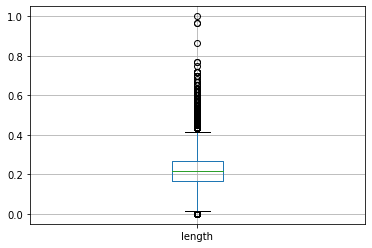

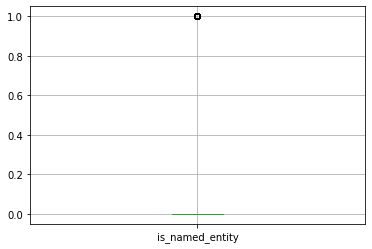

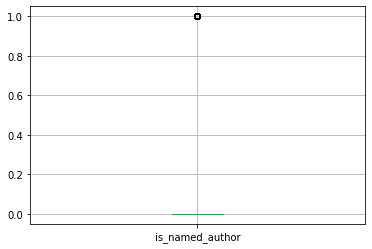

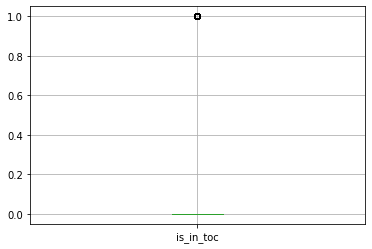

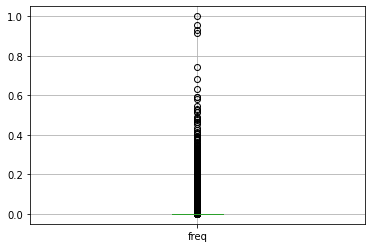

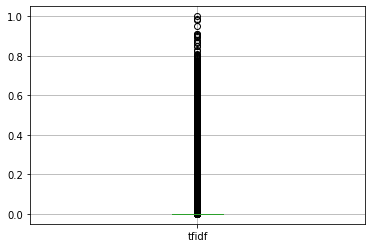

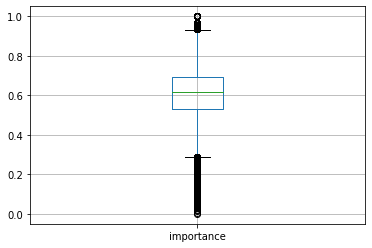

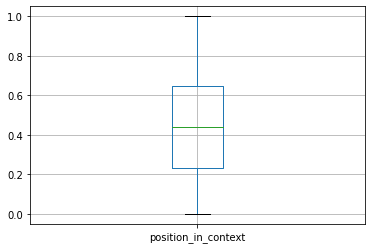

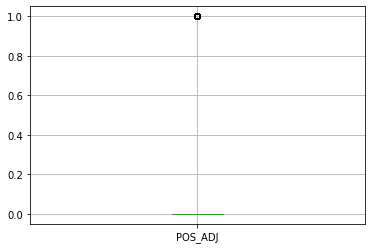

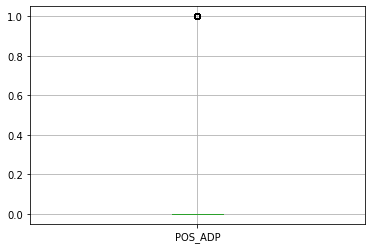

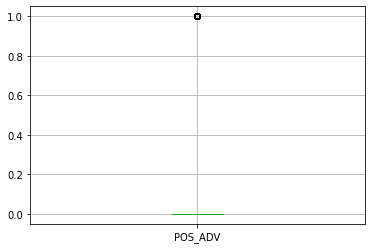

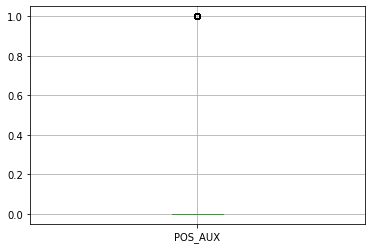

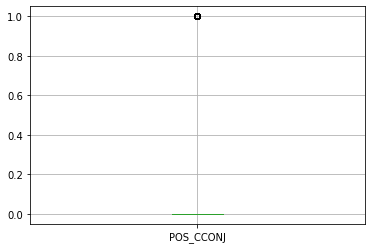

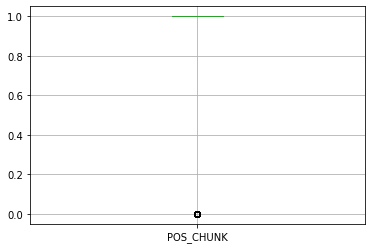

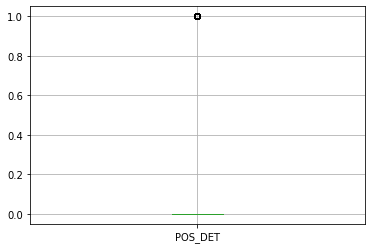

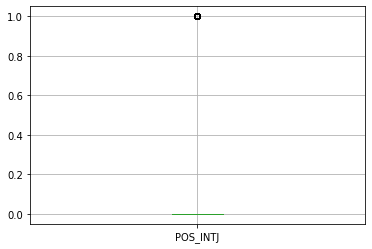

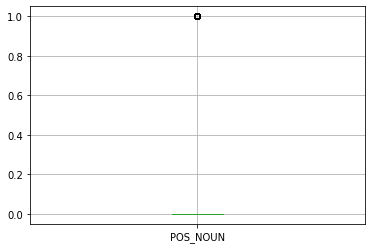

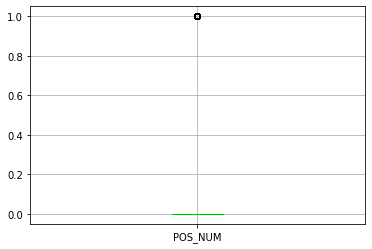

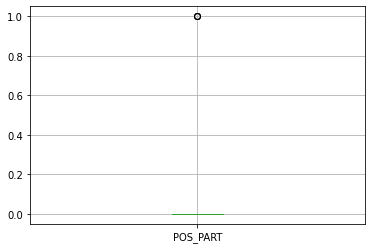

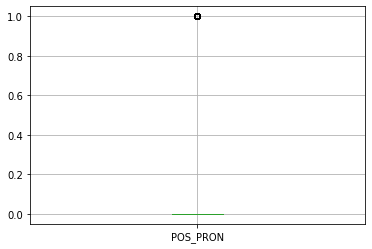

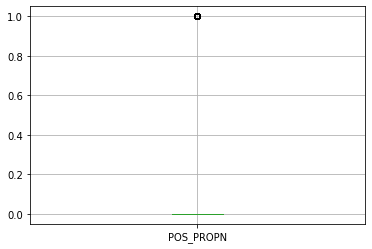

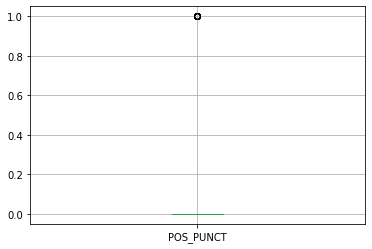

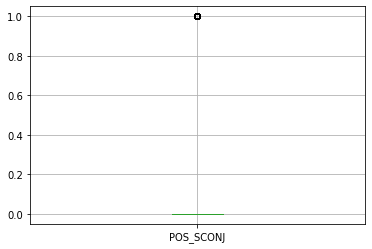

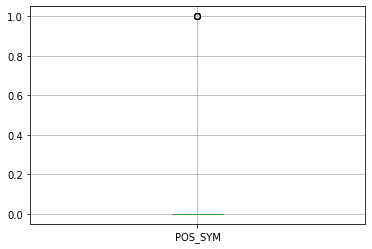

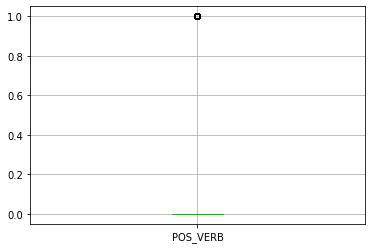

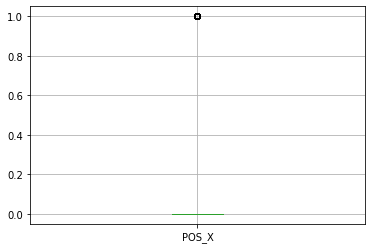

In [202]:
for column in df_scaled.drop(['target'], axis=1):
    plt.figure()
    df_scaled.boxplot([column])

### Correlation heatmap

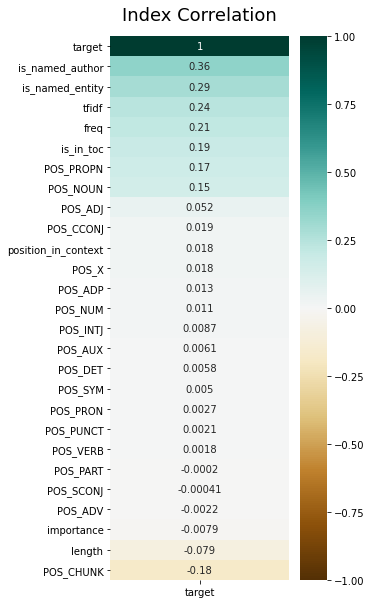

In [203]:
plt.figure(figsize=(4, 10))

heatmap = sns.heatmap(df_scaled.corr()[['target']].sort_values(by='target', ascending=False), 
                      vmin=-1, 
                      vmax=1,
                      annot=True,
                      cmap='BrBG')

heatmap.set_title('Index Correlation', fontdict={'fontsize':18}, pad=16);

plt.show()

# 3. Train and test the models

In [205]:
X = df_scaled.drop('target', axis= 1)
y = df_scaled.target

In [206]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

## 3.1. Logistic regression

In [207]:
model_LR = LogisticRegression(random_state=42)

In [208]:
#gridsearch
params_LR = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}

In [209]:
grid_search_cv_LR = GridSearchCV(model_LR, params_LR, 
                              scoring="accuracy",
                              n_jobs=-1, verbose=1, cv=10)

grid_search_cv_LR.fit(X_train, y_train)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


/Users/bertagrim/opt/anaconda3/envs/DataScience/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan 0.98908236        nan 0.99012832        nan 0.99012394
        nan 0.99033255        nan 0.99036172        nan 0.99037777
        nan 0.9903661         nan 0.99036027]
  category=UserWarning

/Users/bertagrim/opt/anaconda3/envs/DataScience/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



GridSearchCV(cv=10, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.001, 0.009, 0.01, 0.09, 1, 5, 10, 25],
                         'penalty': ['l1', 'l2']},
             scoring='accuracy', verbose=1)

In [210]:
grid_search_cv_LR.best_params_

{'C': 5, 'penalty': 'l2'}

In [225]:
log_reg = LogisticRegression(random_state=42, penalty='l2', C=5, max_iter=200)

In [226]:
log_reg.fit(X_train, y_train)

y_pred_LR = log_reg.predict(X_test)

/Users/bertagrim/opt/anaconda3/envs/DataScience/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



#### Metrics

In [227]:
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_LR)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_LR)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_LR)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_LR)))

Accuracy Score : 0.9903953318745441
Precision Score : 0.6892361111111112
Recall Score : 0.21298283261802575
F1 Score : 0.3254098360655738


In [215]:
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred_LR)))

Confusion Matrix : 
[[169332    179]
 [  1468    396]]


In [228]:
cv_scores_LR = cross_validate(log_reg, X, y, cv=10,
                        scoring=('accuracy', 'precision', 'recall', 'f1'),
                        return_train_score=True)

for item in cv_scores_LR:
    print(str(item) +': '+ str(cv_scores_LR[item]))

#cv_scores_LR = np.mean(cv_scores_LR).round(3)
#print("\nAverage 10-Fold CV scores {}".format(cv_scores))

/Users/bertagrim/opt/anaconda3/envs/DataScience/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

/Users/bertagrim/opt/anaconda3/envs/DataScience/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    htt

fit_time: [20.29582906 18.52430916 17.55499697 24.71333599 19.39239383 18.27928114
 18.63745189 17.70426011 18.25257397 24.56722808]
score_time: [0.12858701 0.13211012 0.13146091 0.35745001 0.13448    0.14701009
 0.13192701 0.13126707 0.13193297 0.13071704]
test_accuracy: [0.99081552 0.99116552 0.99031358 0.99125888 0.99139893 0.98936828
 0.99151563 0.98937995 0.98916989 0.98905318]
train_accuracy: [0.99033692 0.99030452 0.99040307 0.99029544 0.99023709 0.99051329
 0.9902319  0.99051459 0.99055867 0.99052885]
test_precision: [0.77007299 0.87029289 0.80588235 0.76420455 0.74146341 0.57228916
 0.78888889 0.53148615 0.51083591 0.46666667]
train_precision: [0.69572301 0.69208692 0.70581065 0.69690547 0.68760611 0.7146771
 0.68394649 0.72555464 0.73215751 0.70651769]
test_recall: [0.22566845 0.22269807 0.14668094 0.28770053 0.32513369 0.10160428
 0.30374332 0.22566845 0.17647059 0.02245989]
train_recall: [0.20301914 0.20061802 0.20644164 0.19541186 0.19255913 0.21704505
 0.19446095 0.209913

In [230]:
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_logcv)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_logcv)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_logcv)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_logcv)))

Accuracy Score : 0.9903953318745441
Precision Score : 0.6905594405594405
Recall Score : 0.2119098712446352
F1 Score : 0.3243021346469622


#### Explainability

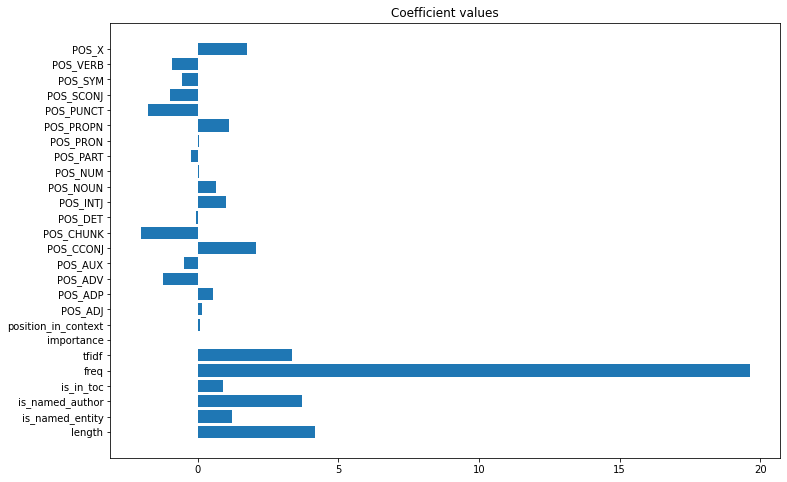

In [250]:
plt.figure(figsize=(12,8))
plt.barh(X.columns,log_reg.coef_[0]) #potser log_ref_cv?
plt.title("Coefficient values")
plt.show()

In [251]:
y_proba = log_reg.predict_proba(X_test)#check what this is

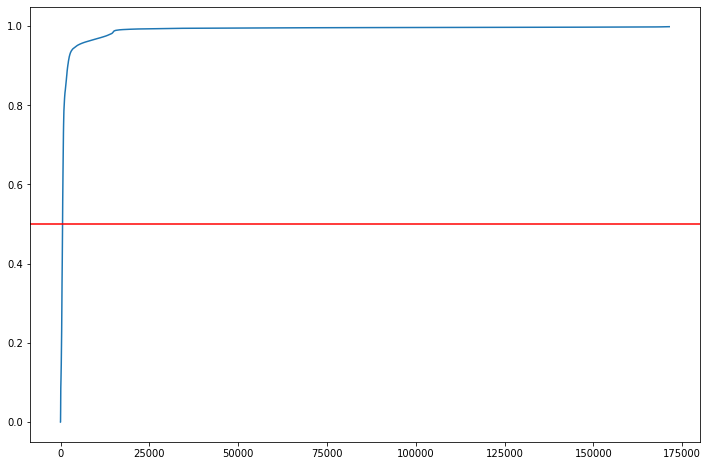

In [254]:
plt.figure(figsize=(12,8))
plt.plot(np.sort(y_proba[:,0]))
plt.axhline(0.5, c='r')
plt.show()

### 3.2. Random forest

In [231]:
model_RF = RandomForestClassifier(random_state=42)

In [245]:
params_RF = {'n_estimators': [50, 100, 200],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [50, 100],
               #'min_samples_split': [2, 5, 10],
               #'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

In [246]:
grid_search_cv_RF = GridSearchCV(model_RF, params_RF, 
                              scoring="f1",
                              n_jobs=-1, verbose=1, cv=10)

grid_search_cv_RF.fit(X_train, y_train)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


KeyboardInterrupt: 

In [ ]:
grid_search_cv_RF.best_params_

In [236]:
rand_forest = RandomForestClassifier(n_estimators=100, random_state=42)

In [237]:
rand_forest.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [238]:
y_pred_RF = rand_forest.predict(X_test)

#### Metrics

In [239]:
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_RF)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_RF)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_RF)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_RF)))

Accuracy Score : 0.9906053975200584
Precision Score : 0.7041800643086816
Recall Score : 0.2349785407725322
F1 Score : 0.35237329042638776


In [240]:
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred_RF)))

Confusion Matrix : 
[[169327    184]
 [  1426    438]]


In [ ]:
cv_scores_LR = cross_validate(log_reg, X, y, cv=3,
                        scoring=('accuracy', 'precision', 'recall', 'f1'),
                        return_train_score=True)

print(scores['accuracy'])
print(scores['precision'])
print(scores['recall'])
print(scores['f1'])

#cv_scores_LR = np.mean(cv_scores_LR).round(3)
#print("\nAverage 10-Fold CV scores {}".format(cv_scores))

#### Explainability

In [248]:
importance = rand_forest.feature_importances_

list_of_importance=zip(X.columns.tolist(), importance.tolist())

print(list(list_of_importance))

[('length', 0.08024736530622699), ('is_named_entity', 0.04188629646270052), ('is_named_author', 0.09200166888491386), ('is_in_toc', 0.01754574200048623), ('freq', 0.18933341689815858), ('tfidf', 0.11575406560822038), ('importance', 0.23444122432493802), ('position_in_context', 0.19514259797274336), ('POS_ADJ', 0.0028244288480706787), ('POS_ADP', 0.0005358364978282993), ('POS_ADV', 0.0014240566605109046), ('POS_AUX', 0.0003219109434460699), ('POS_CCONJ', 0.00044587980579309473), ('POS_CHUNK', 0.0050197944847062215), ('POS_DET', 0.0002089570975808378), ('POS_INTJ', 0.00029770996606250143), ('POS_NOUN', 0.008654911741373658), ('POS_NUM', 0.0005256926342406587), ('POS_PART', 3.759940519008759e-08), ('POS_PRON', 0.00019538815167637248), ('POS_PROPN', 0.009129009420934874), ('POS_PUNCT', 9.693111619209582e-05), ('POS_SCONJ', 0.0001101108758064606), ('POS_SYM', 4.59725538545761e-05), ('POS_VERB', 0.0033142962488630283), ('POS_X', 0.0004966978952665072)]


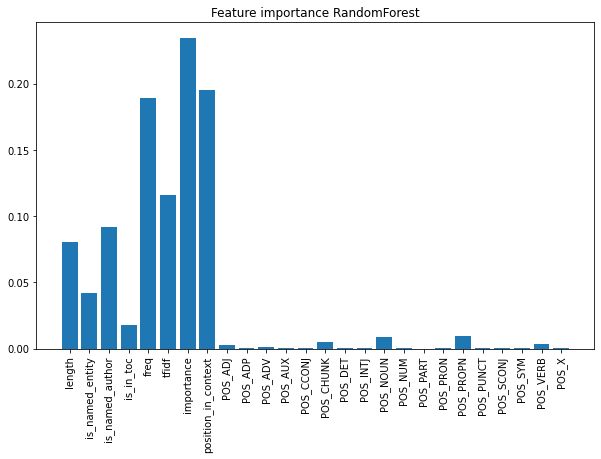

In [249]:
plt.figure(figsize=(10, 6))

arr = [x for x in range(len(importance))]
labels = X.columns.tolist()
plt.bar(arr, importance)
plt.title('Feature importance RandomForest')
plt.xticks(arr, labels, rotation=90)
plt.show()
#sort it

# RandomForest with under and oversampling

## Oversampling

In [255]:
smote = SMOTE(random_state =7)
X_sm, y_sm = smote.fit_resample(X_train, y_train)

In [256]:
print('\nBefore OVER-sampling\n', y_train.value_counts())
print('\nAfter OVER-sampling\n', y_sm.value_counts())


Before OVER-sampling
 0.0    678012
1.0      7484
Name: target, dtype: int64

After OVER-sampling
 0.0    678012
1.0    678012
Name: target, dtype: int64


In [ ]:
rand_forest.fit(X_sm, y_sm)

In [ ]:
y_sm_RF = rand_forest.predict(X_test)

In [ ]:
print('Accuracy Score : ' + str(accuracy_score(y_test,y_sm_RF)))
print('Precision Score : ' + str(precision_score(y_test,y_sm_RF)))
print('Recall Score : ' + str(recall_score(y_test,y_sm_RF)))
print('F1 Score : ' + str(f1_score(y_test,y_sm_RF)))

## Undersampling

In [269]:
sampler = ClusterCentroids()
#sampler=CondensedNearestNeighbour()
X_cc, y_cc = sampler.fit_resample(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
print('\nBefore UNDER-sampling\n', y_train.value_counts())
print('\nAfter UNDER-resampling\n', y_cc.value_counts())

In [ ]:
rand_forest.fit(X_cc, y_cc)

In [ ]:
y_cc_RF = rand_forest.predict(X_test)

In [ ]:
print('Accuracy Score : ' + str(accuracy_score(y_test,y_cc_RF)))
print('Precision Score : ' + str(precision_score(y_test,y_cc_RF)))
print('Recall Score : ' + str(recall_score(y_test,y_cc_RF)))
print('F1 Score : ' + str(f1_score(y_test,y_cc_RF)))